# Part 1

In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
import matplotlib.pyplot as plt
import time

## 2.1 Pictionary Dataset
Dataset has been downloaded from moodle.

In [3]:
pictionary_data = np.load('../data.npy', allow_pickle=True) # dataset was pickled

## 2.2 Exploratory Data Analysis

Exploring shape and type of data

In [4]:
type(pictionary_data), pictionary_data.shape

(numpy.ndarray, (1500, 5))

So, we have 1500 data points with 5 features each.

### Task 1
We wish to explore the distribution of labels in the dataset (4th column). We may use a simple bar plot to compare the number of labels in the dataset.

In [5]:
columns = {
    'game_id': 0,
    'resnet_emb': 1,
    'vit_emb': 2,
    'label': 3,
    'guess_time': 4
}

pict_labels = pictionary_data[:, columns['label']]
# pict_labels

In [6]:
unique_labels, label_frequencies = np.unique(pict_labels, return_counts=True)

In [7]:
# Plotting using matplotlib
plt.figure(figsize=(180, 100))
plt.xlabel('Labels', fontsize=90)
plt.ylabel('Number of Occurances', fontsize=90)
plt.title('Task 1', fontsize=90)
plt.xticks(fontsize=60, rotation='vertical')
plt.yticks(fontsize=80, ticks=list(range(max(label_frequencies) + 1)))
plt.bar(unique_labels, label_frequencies)
plt.show()

However, this graph isn't readable - we will will first try to plot in a sorted order for a better sense of things.

In [8]:
# sorting by frequencies
sorted_indices = np.argsort(label_frequencies)
unique_labels = unique_labels[sorted_indices]
label_frequencies = label_frequencies[sorted_indices]

plt.figure(figsize=(180, 100))
plt.xlabel('Labels', fontsize=90)
plt.ylabel('Number of Occurances', fontsize=90)
plt.title('Task 1', fontsize=90)
plt.xticks(fontsize=60, rotation='vertical')
plt.yticks(fontsize=80, ticks=list(range(max(label_frequencies) + 1)))
plt.bar(unique_labels, label_frequencies)
plt.show()

We explore data with minimum and maximum values - 

In [9]:
max_frequency = np.max(label_frequencies)
min_frequency = np.min(label_frequencies)

search_mask = label_frequencies == max_frequency
print("Max frequency {} is attained at {}".format(max_frequency, unique_labels[search_mask]))

search_mask = label_frequencies == min_frequency
print("Min frequency {} is attained at {}".format(min_frequency, unique_labels[search_mask]))

Max frequency 26 is attained at ['flute']
Min frequency 1 is attained at ['scary' 'dig' 'rainy' 'draw' 'rifle' 'throne' 'knit' 'knock']


For a better representation of the data we will present graphs with only a subset of the labels but with the minimum and maximum frequencies

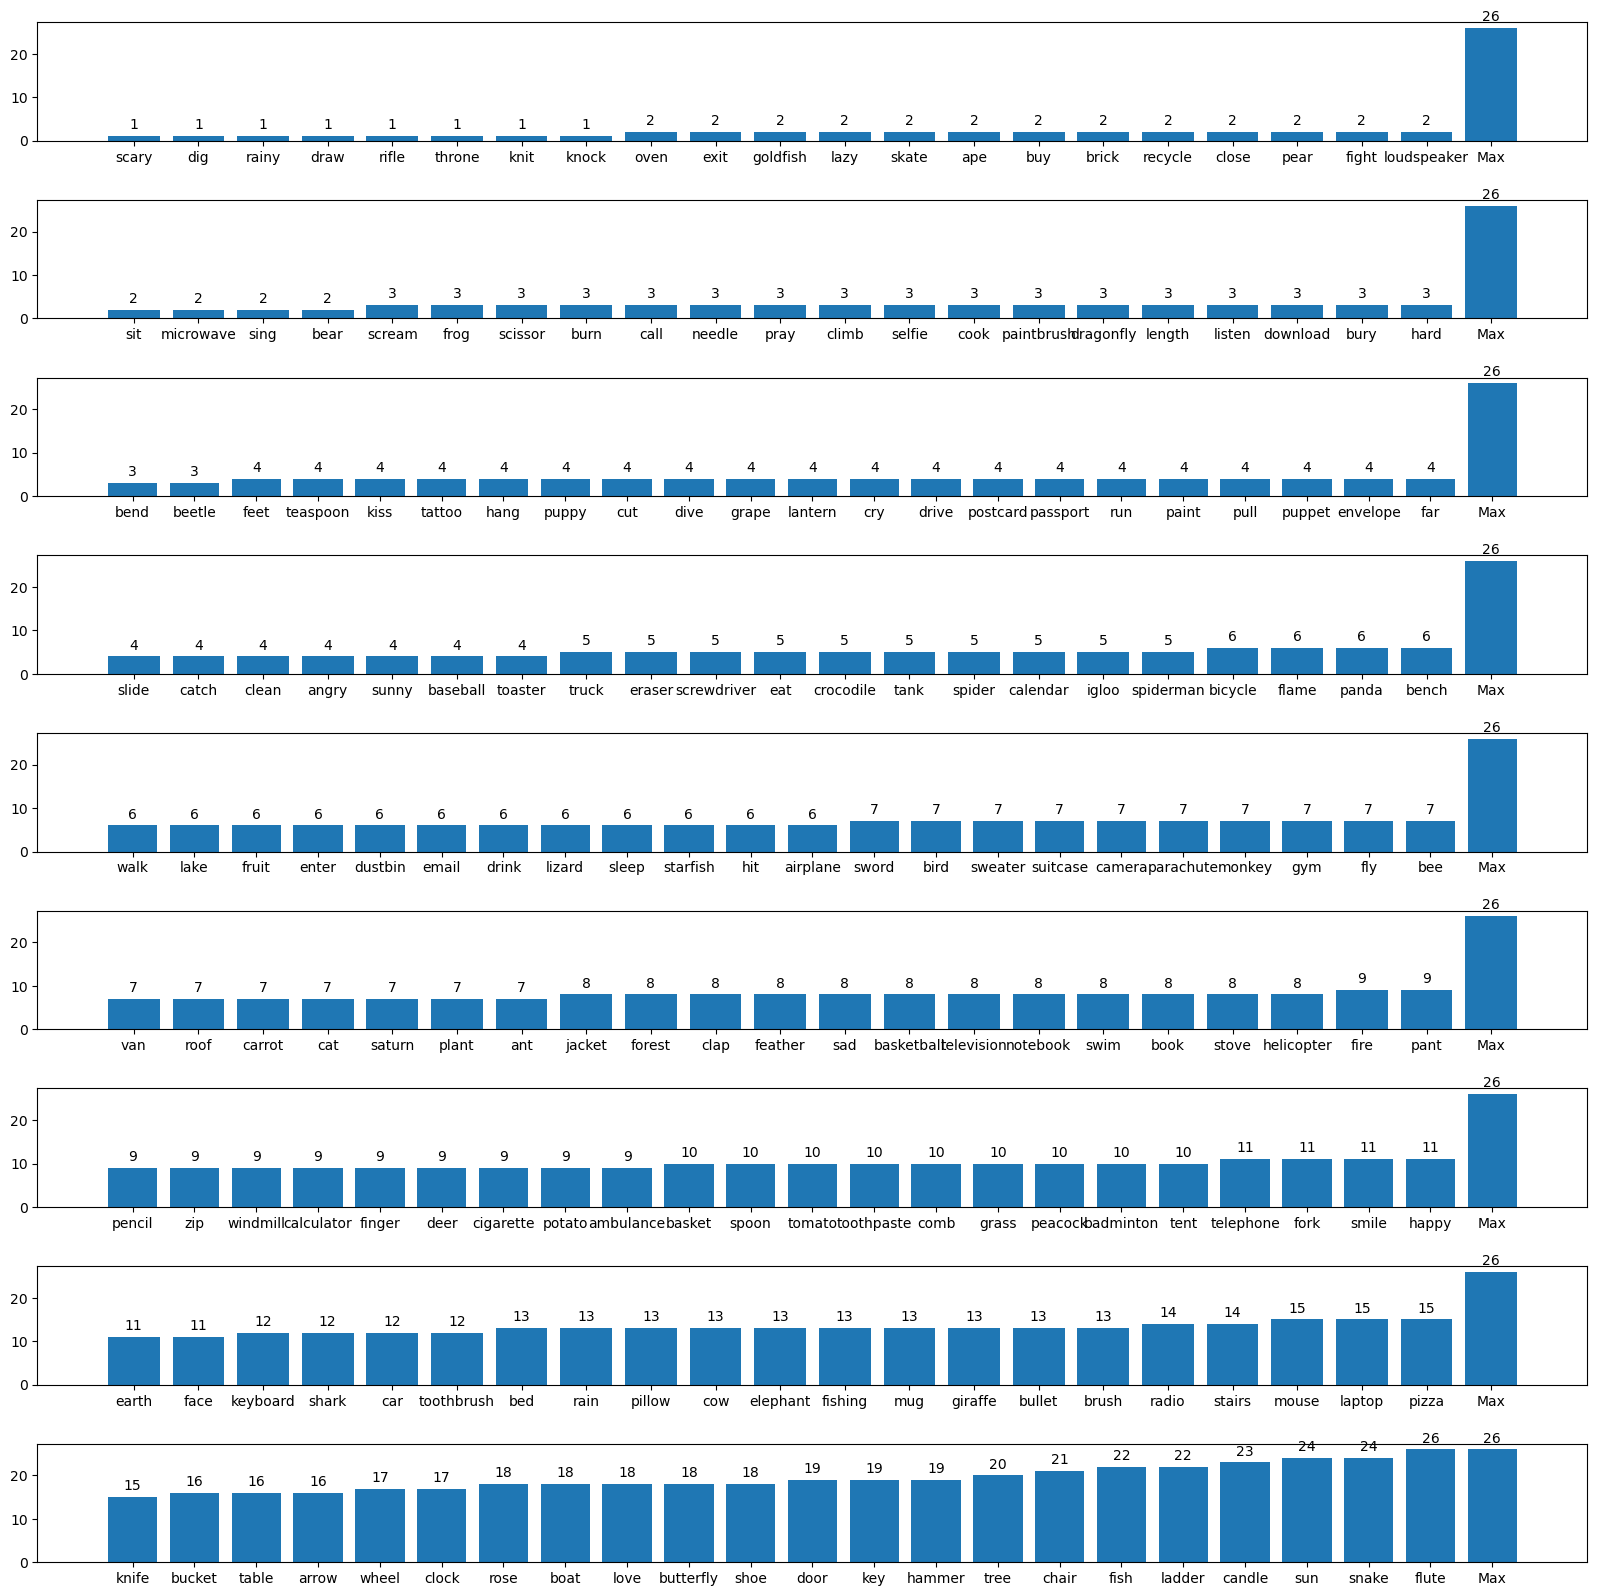

In [10]:
num_rows = 9
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(20, 20))

for i in range(num_rows):
    x_labels = unique_labels[int((i)*len(unique_labels)/num_rows): min(len(unique_labels), int((i+1)*len(unique_labels)/num_rows))]
    x_labels = np.append(x_labels, 'Max')
    
    y_frequencies = label_frequencies[int((i)*len(unique_labels)/num_rows): min(len(unique_labels), int((i+1)*len(unique_labels)/num_rows))]
    y_frequencies = np.append(y_frequencies, max_frequency)
    
    bars = axes[i].bar(x_labels, y_frequencies)
    
    for bar in bars:
        # This piece of code has been asked from GPT
        height = bar.get_height()
        axes[i].annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Adding padding between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

## 2.3 KNN Implementation

### Task 1

We create a KNN class that accepts the following hyperparameters - 
1. k: Number of nearest neighbours to compare with 
2. enconding: ResNet or ViT encoding
3. dist_metric: distance metric to be considered (Euclidean, Manhattan, Cosine)
4. split: % of data to be taken as validation
5. weighting: weigh by $1/(1 + distance)$

In [11]:
class KNN:
    '''
        Some variables
    '''
    valid_encodings = (1, 2,)
    valid_distance_metrics = ('euclidean', 'manhattan', 'cosine', 'minkowski3', 'minkowski4', 'chebyshev')
    columns = {
        'game_id': 0,
        'resnet_emb': 1,
        'vit_emb': 2,
        'label': 3,
        'guess_time': 4
    }
    
    
    '''
        Distance Metrics
    '''
    # Euclidean distance metric
    def Euclidean(self, sample1, sample2):
        return np.sqrt(np.sum((sample1 - sample2)**2))   
    
    # Manhattan distance
    def Manhattan(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)) 
    
    # Cosine distance
    def Cosine(self, sample1, sample2):
        dot_product = np.dot(sample1, sample2)
        norm_point1 = np.linalg.norm(sample1)
        norm_point2 = np.linalg.norm(sample2)
        return 1 - dot_product / (norm_point1 * norm_point2)
    
    # calculating l3 Minkowski Distance
    def Minkowski3(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)**3) 
    
    # calculating l4 Minkowski Distance
    def Minkowski4(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)**4)
    
    # Chebyshev distance
    def Chebyshev(self, sample1, sample2):
        return np.max(np.abs(sample1 - sample2))
    
    
    '''
        Data Preprocessing Techniques
    '''
    # splits data into train and test
    def split_data(self, split):
        split_index = round((100 - split)/100 * len(self.data_encodings))
        self.train_labels, self.test_labels = self.data_labels[:split_index], self.data_labels[split_index:] 
        self.train_encodings, self.test_encodings = self.data_encodings[:split_index], self.data_encodings[split_index:]
          
        
    '''
        Functions that return outputs
    '''        
    # returns nearest neighbour for a given data point
    def predict(self, sample):
        # compute distances from all train encodings
        distances_from_all_train_encodings = [
            [self.dist_metric(self.train_encodings[i], sample), self.train_labels[i]] 
                for i in range(len(self.train_encodings))
        ]
        distances_from_all_train_encodings.sort()
        distances_from_all_train_encodings = np.array(distances_from_all_train_encodings)
        
        # extracting k nearest neighbours
        nearest_neighbour_labels = distances_from_all_train_encodings[:, 1][:self.k]
        
        # code for when we weigh by inverse of distance
        if self.weigh:
            unique_nearest_labels = np.unique(nearest_neighbour_labels)
            nearest_neighbour_distances = distances_from_all_train_encodings[:, 0][:self.k]
            
            # adding 1/(1+weight) for all
            nearest_weighted = {}
            for i in unique_nearest_labels:
                nearest_weighted[i] = 0
            
            for i in range(len(nearest_neighbour_distances)):
                nearest_weighted[nearest_neighbour_labels[i]] += 1/(1 + float(nearest_neighbour_distances[i]))
                
            # maximum statement from GPT
            return max(nearest_weighted, key=nearest_weighted.get)
            
        # fining most repeated neighbour - tie breaking is in alphabetical order
        unique_nearest_labels, label_frequencies = np.unique(nearest_neighbour_labels, return_counts=True)
        max_label_frequency = max(label_frequencies)
        for i in range(len(unique_nearest_labels)):
            if label_frequencies[i] == max_label_frequency:
                return unique_nearest_labels[i]
        
        return unique_nearest_labels[-1]
    
    # returns learning metrics
    def run(self):
        # Predict all labels
        predicted_labels = np.array([self.predict(sample) for sample in self.test_encodings])
        
        accuracy = accuracy_score(self.test_labels, predicted_labels)
        precision = precision_score(self.test_labels, predicted_labels, average='micro')
        recall = recall_score(self.test_labels, predicted_labels, average='micro')
        f1 = f1_score(self.test_labels, predicted_labels, average='micro')
        
        return accuracy, precision, recall, f1
            
    
    # init function to create object
    def __init__(self, k = 1, encoding = 1, dist_metric = 'euclidean', validation_setting = True, split = 20, weigh = False, dataset = pictionary_data, train_data = None, test_data = None):
        # Checking whether inputs are valid:
        if (k <= 0 or not isinstance(k, int)):
            raise ValueError("k should be a positive natural number")
        if (not encoding in self.valid_encodings):
            raise ValueError("Encoding accepts 1 for resnet and 2 for ViT")
        if (not dist_metric in self.valid_distance_metrics):
            raise ValueError("Distance metric should belong to {}".format(valid_distance_metrics))
        if (split <= 0 or split >= 100):
            raise ValueError("Not a valid split")
        if (not isinstance(weigh, bool)):
            raise ValueError("Weigh is a boolean attribute")
            
        distance_metric_functions = {
            'euclidean': self.Euclidean,
            'manhattan': self.Manhattan,
            'cosine': self.Cosine,
            'minkowski3': self.Minkowski3,
            'minkowski4': self.Minkowski4,
            'chebyshev': self.Chebyshev
        }
        
        # setting varibles
        self.k = k
        self.encoding = encoding
        self.dist_metric = distance_metric_functions[dist_metric]
        self.weigh = weigh
        
        if validation_setting:
            # setting split
            self.split = split

            # Extracting features and labels from dataset
            self.data_encodings = dataset[:, encoding]
            self.data_labels = dataset[:, self.columns['label']]

            # making an array of arrays into a single array
            self.data_encodings = np.array([np.squeeze(nested_array) for nested_array in self.data_encodings])

            # splitting into train and validation
            self.split_data(split)
        else:
            self.train_labels = train_data[:, self.columns['label']]
            self.train_encodings = train_data[:, encoding]
            self.train_encodings = np.array([np.squeeze(nested_array) for nested_array in self.train_encodings])
            
            self.test_labels = test_data[:, self.columns['label']]
            self.test_encodings = test_data[:, encoding]
            self.test_encodings = np.array([np.squeeze(nested_array) for nested_array in self.test_encodings])

In [12]:
# dummy instantiation time
start_time = time.time()
myKNN = KNN(k = 9, encoding = 2, weigh = True, dist_metric = 'cosine')
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for instantiation\n')

# dummy run time
start_time = time.time()
accuracy, precision, recall, f1 = myKNN.run()
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for inference\n')

print(f'Accuracy: {accuracy:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Took 0.00271344 seconds for instantiation

Took 2.37592292 seconds for inference

Accuracy: 0.29666667
Precision: 0.29666667
Recall: 0.29666667
F1 Score: 0.29666667


In [13]:
# dummy instantiation time for non validation setting
split_index = round((100 - 20)/100 * len(pictionary_data))
train_dataset = pictionary_data[:split_index]
test_dataset = pictionary_data[split_index:]

start_time = time.time()
myKNN = KNN(k = 9, encoding = 2, weigh = True, dist_metric = 'cosine', 
           validation_setting = False,
           train_data = train_dataset, test_data = test_dataset)
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for instantiation\n')

# dummy run time
start_time = time.time()
accuracy, precision, recall, f1 = myKNN.run()
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for inference\n')

print(f'Accuracy: {accuracy:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Took 0.00237823 seconds for instantiation

Took 2.55346584 seconds for inference

Accuracy: 0.29666667
Precision: 0.29666667
Recall: 0.29666667
F1 Score: 0.29666667


## 2.4 Hyperparameter Tuning

### Task  2

We will compare all variants of the KNN model keeping `split=20` and `weigh=true`

In [14]:
all_variants = []
table_headers = ['Accuracy', 'k', 'Encoder', 'Distance Metric']

valid_distance_metrics = myKNN.valid_distance_metrics
valid_encodings = myKNN.valid_encodings
encoder_strings = ["", "ResNet", "ViT"]

total_checks = int(len(pictionary_data)**0.5 + 1) * len(valid_distance_metrics) * len(valid_encodings)

current_i = 0
for current_k in range(1, int(len(pictionary_data)**0.5 + 1)): # since we take till sqrt(N)
    for distance_metric in valid_distance_metrics:
        for encoding in valid_encodings:
            curKNN = KNN(k = current_k, encoding = encoding, 
                         dist_metric = distance_metric, 
                         split = 20, weigh = True, 
                         dataset = pictionary_data)
            accuracy, precision, recall, f1 = curKNN.run()
            
            all_variants.append([accuracy, current_k, encoder_strings[encoding], distance_metric])
            
            print(".", end = "")
            current_i += 1
            if (current_i % 20 == 0):
                print("- {}/{} -".format(current_i, total_checks), end = "")
print()
            
all_variants.sort(reverse = True)
best_variants = all_variants[:min(len(all_variants), 20)]

print(tabulate(best_variants, table_headers, tablefmt="grid"))

....................- 20/468 -....................- 40/468 -....................- 60/468 -....................- 80/468 -....................- 100/468 -....................- 120/468 -....................- 140/468 -....................- 160/468 -....................- 180/468 -....................- 200/468 -....................- 220/468 -....................- 240/468 -....................- 260/468 -....................- 280/468 -....................- 300/468 -....................- 320/468 -....................- 340/468 -....................- 360/468 -....................- 380/468 -....................- 400/468 -....................- 420/468 -....................- 440/468 -................
+------------+-----+-----------+-------------------+
|   Accuracy |   k | Encoder   | Distance Metric   |
+============+=====+===========+===================+
|   0.313333 |  10 | ViT       | euclidean         |
+------------+-----+-----------+-------------------+
|   0.31     |   9 | ViT       | euclide



From the tabulation, the **best accuracy** is achieved for 


    k = 10 using the ViT encoding and Euclidean distance metric

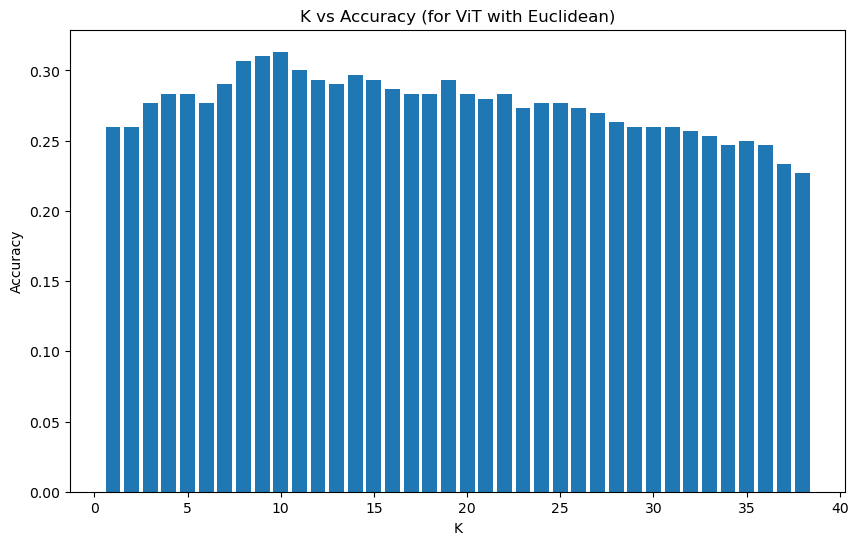

In [15]:
# Plotting k vs accuracy for ViT encoding and Euclidean distance metric
relevant_datapoints = {}

for row in all_variants:
    if row[2] == 'ViT' and row[3] == 'euclidean':
        relevant_datapoints[row[1]] = row[0]

keys = list(relevant_datapoints.keys())
values = list(relevant_datapoints.values())

plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy (for ViT with Euclidean)')
plt.show()

## 2.5 Testing 

### Tasks - creating code to run ./eval.sh test.npy

In [16]:
split_index = round((100 - 20)/100 * len(pictionary_data))
train_dataset = pictionary_data[:split_index]
test_dataset = pictionary_data[split_index:]

train_dataset.shape

(1200, 5)

In [17]:
# Saving these
np.save("test.npy", test_dataset)
np.save("train.npy", train_dataset)

In [18]:
%%writefile run_knn_script.py

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

class KNN:
    '''
        Some variables
    '''
    valid_encodings = (1, 2,)
    valid_distance_metrics = ('euclidean', 'manhattan', 'cosine', 'minkowski3', 'minkowski4', 'chebyshev')
    columns = {
        'game_id': 0,
        'resnet_emb': 1,
        'vit_emb': 2,
        'label': 3,
        'guess_time': 4
    }
    
    
    '''
        Distance Metrics
    '''
    # Euclidean distance metric
    def Euclidean(self, sample1, sample2):
        return np.sqrt(np.sum((sample1 - sample2)**2))   
    
    # Manhattan distance
    def Manhattan(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)) 
    
    # Cosine distance
    def Cosine(self, sample1, sample2):
        dot_product = np.dot(sample1, sample2)
        norm_point1 = np.linalg.norm(sample1)
        norm_point2 = np.linalg.norm(sample2)
        return 1 - dot_product / (norm_point1 * norm_point2)
    
    # calculating l3 Minkowski Distance
    def Minkowski3(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)**3) 
    
    # calculating l4 Minkowski Distance
    def Minkowski4(self, sample1, sample2):
        return np.sum(np.abs(sample1 - sample2)**4)
    
    # Chebyshev distance
    def Chebyshev(self, sample1, sample2):
        return np.max(np.abs(sample1 - sample2))
    
    
    '''
        Data Preprocessing Techniques
    '''
    # splits data into train and test
    def split_data(self, split):
        split_index = round((100 - split)/100 * len(self.data_encodings))
        self.train_labels, self.test_labels = self.data_labels[:split_index], self.data_labels[split_index:] 
        self.train_encodings, self.test_encodings = self.data_encodings[:split_index], self.data_encodings[split_index:]
          
        
    '''
        Functions that return outputs
    '''        
    # returns nearest neighbour for a given data point
    def predict(self, sample):
        # compute distances from all train encodings
        distances_from_all_train_encodings = [
            [self.dist_metric(self.train_encodings[i], sample), self.train_labels[i]] 
                for i in range(len(self.train_encodings))
        ]
        distances_from_all_train_encodings.sort()
        distances_from_all_train_encodings = np.array(distances_from_all_train_encodings)
        
        # extracting k nearest neighbours
        nearest_neighbour_labels = distances_from_all_train_encodings[:, 1][:self.k]
        
        # code for when we weigh by inverse of distance
        if self.weigh:
            unique_nearest_labels = np.unique(nearest_neighbour_labels)
            nearest_neighbour_distances = distances_from_all_train_encodings[:, 0][:self.k]
            
            # adding 1/(1+weight) for all
            nearest_weighted = {}
            for i in unique_nearest_labels:
                nearest_weighted[i] = 0
            
            for i in range(len(nearest_neighbour_distances)):
                nearest_weighted[nearest_neighbour_labels[i]] += 1/(1 + float(nearest_neighbour_distances[i]))
                
            return max(nearest_weighted, key=nearest_weighted.get)
            
        # fining most repeated neighbour - tie breaking is in alphabetical order
        unique_nearest_labels, label_frequencies = np.unique(nearest_neighbour_labels, return_counts=True)
        max_label_frequency = max(label_frequencies)
        for i in range(len(unique_nearest_labels)):
            if label_frequencies[i] == max_label_frequency:
                return unique_nearest_labels[i]
        
        return unique_nearest_labels[-1]
    
    # returns learning metrics
    def run(self):
        # Predict all labels
        predicted_labels = np.array([self.predict(sample) for sample in self.test_encodings])
        
        accuracy = accuracy_score(self.test_labels, predicted_labels)
        precision = precision_score(self.test_labels, predicted_labels, average='micro')
        recall = recall_score(self.test_labels, predicted_labels, average='micro')
        f1 = f1_score(self.test_labels, predicted_labels, average='micro')
        
        return accuracy, precision, recall, f1
            
    
    # init function to create object
    def __init__(self, k = 1, encoding = 1, dist_metric = 'euclidean', validation_setting = True, split = 20, weigh = False, dataset = None, train_data = None, test_data = None):
        # Checking whether inputs are valid:
        if (k <= 0 or not isinstance(k, int)):
            raise ValueError("k should be a positive natural number")
        if (not encoding in self.valid_encodings):
            raise ValueError("Encoding accepts 1 for resnet and 2 for ViT")
        if (not dist_metric in self.valid_distance_metrics):
            raise ValueError("Distance metric should belong to {}".format(valid_distance_metrics))
        if (split <= 0 or split >= 100):
            raise ValueError("Not a valid split")
        if (not isinstance(weigh, bool)):
            raise ValueError("Weigh is a boolean attribute")
            
        distance_metric_functions = {
            'euclidean': self.Euclidean,
            'manhattan': self.Manhattan,
            'cosine': self.Cosine,
            'minkowski3': self.Minkowski3,
            'minkowski4': self.Minkowski4,
            'chebyshev': self.Chebyshev
        }
        
        # setting varibles
        self.k = k
        self.encoding = encoding
        self.dist_metric = distance_metric_functions[dist_metric]
        self.weigh = weigh
        
        if validation_setting:
            # setting split
            self.split = split

            # Extracting features and labels from dataset
            self.data_encodings = dataset[:, encoding]
            self.data_labels = dataset[:, self.columns['label']]

            # making an array of arrays into a single array
            self.data_encodings = np.array([np.squeeze(nested_array) for nested_array in self.data_encodings])

            # splitting into train and validation
            self.split_data(split)
        else:
            self.train_labels = train_data[:, self.columns['label']]
            self.train_encodings = train_data[:, encoding]
            self.train_encodings = np.array([np.squeeze(nested_array) for nested_array in self.train_encodings])
            
            self.test_labels = test_data[:, self.columns['label']]
            self.test_encodings = test_data[:, encoding]
            self.test_encodings = np.array([np.squeeze(nested_array) for nested_array in self.test_encodings])

Overwriting run_knn_script.py


## 2.6 Optimization

### 1 - Optimize KNN implementation

In [14]:
class optKNN:
    '''
        Some variables
    '''
    valid_encodings = (1, 2,)
    valid_distance_metrics = ('euclidean', 'manhattan', 'cosine')
    columns = {
        'game_id': 0,
        'resnet_emb': 1,
        'vit_emb': 2,
        'label': 3,
        'guess_time': 4
    }
    
    
    '''
        Distance Metrics
    '''
    # Euclidean distance metric
    def Euclidean(self, sample):
        return np.sqrt(np.sum((self.train_encodings - sample) ** 2, axis=1)) # neglecting sqrt to make it faster
    
    # Manhattan distance
    def Manhattan(self, sample):
        return np.sqrt(np.sum(np.abs(self.train_encodings - sample), axis=1))
    
    # Cosine distance
    def Cosine(self, sample):
        dot_product = np.dot(sample1, sample2)
        norm_points = np.linalg.norm(self.train_encodings, axis=1)
        norm_point = np.linalg.norm(sample)
        return 1 - dot_product / (norm_points * norm_point)    
    
    '''
        Data Preprocessing Techniques
    '''
    # splits data into train and test
    def split_data(self, split):
        split_index = round((100 - split)/100 * len(self.data_encodings))
        self.train_labels, self.test_labels = self.data_labels[:split_index], self.data_labels[split_index:] 
        self.train_encodings, self.test_encodings = self.data_encodings[:split_index], self.data_encodings[split_index:]

    '''
        Functions that return outputs
    '''        
    # returns nearest neighbour for a given data point
    def predict(self, sample):
        distances_from_all_train_encodings = self.dist_metric(sample)
        
        # Getting 1/(1+weight) of k nearest neighbours
        sorted_indices = np.argsort(distances_from_all_train_encodings)
        nearest_neighbour_distances = distances_from_all_train_encodings[sorted_indices][:self.k]
        weighted_distances = 1 / (1 + nearest_neighbour_distances)

        # Extract k nearest neighbour labels
        nearest_neighbour_labels = self.train_labels[sorted_indices][:self.k]         
        unique_nearest_labels = np.unique(nearest_neighbour_labels)
            
        # adding 1/(1+weight) for all
        nearest_weighted = {}
        for i in unique_nearest_labels:
            nearest_weighted[i] = 0
            
        for i in range(len(nearest_neighbour_distances)):
            nearest_weighted[nearest_neighbour_labels[i]] += 1/(1 + float(nearest_neighbour_distances[i]))
                
        return max(nearest_weighted, key=nearest_weighted.get)
    
    # returns learning metrics
    def run(self):
        # Predict all labels
        predicted_labels = np.array([self.predict(sample) for sample in self.test_encodings])
        
        accuracy = accuracy_score(self.test_labels, predicted_labels)
        precision = precision_score(self.test_labels, predicted_labels, average='micro')
        recall = recall_score(self.test_labels, predicted_labels, average='micro')
        f1 = f1_score(self.test_labels, predicted_labels, average='micro')
        
        return accuracy, precision, recall, f1
            
    
    # init function to create object
    def __init__(self, k = 1, encoding = 1, dist_metric = 'euclidean', split = 20, dataset = pictionary_data):
        # Checking whether inputs are valid:
        if (k <= 0 or not isinstance(k, int)):
            raise ValueError("k should be a positive natural number")
        if (not encoding in self.valid_encodings):
            raise ValueError("Encoding accepts 1 for resnet and 2 for ViT")
        if (not dist_metric in self.valid_distance_metrics):
            raise ValueError("Distance metric should belong to {}".format(valid_distance_metrics))
        if (split <= 0 or split >= 100):
            raise ValueError("Not a valid split")
            
        distance_metric_functions = {
            'euclidean': self.Euclidean,
            'manhattan': self.Manhattan,
            'cosine': self.Cosine,
        }
        
        # setting varibles
        self.k = k
        self.encoding = encoding
        self.dist_metric = distance_metric_functions[dist_metric]
        self.split = split

        # Extracting features and labels from dataset
        self.data_encodings = dataset[:, encoding]
        self.data_labels = dataset[:, self.columns['label']]
                
        self.data_encodings = np.array([np.squeeze(nested_array) for nested_array in self.data_encodings])
                        
        # splitting into train and validation
        self.split_data(split)
        

In [15]:
# dummy instantiation time
start_time = time.time()
myKNN = optKNN(k = 10, encoding = 2, dist_metric = 'manhattan')
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for instantiation\n')

# dummy run time
start_time = time.time()
accuracy, precision, recall, f1 = myKNN.run()
end_time = time.time()
print(f'Took {(end_time - start_time):.8f} seconds for inference\n')

print(f'Accuracy: {accuracy:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Took 0.00358200 seconds for instantiation

Took 0.17700338 seconds for inference

Accuracy: 0.29666667
Precision: 0.29666667
Recall: 0.29666667
F1 Score: 0.29666667


In [25]:
myInitKNN = KNN()
start_time = time.time()
accuracy, precision, recall, f1 = myInitKNN.run()
end_time = time.time()
init_knn_time = end_time - start_time
print(f'Initial KNN Implementation took {(init_knn_time):.8f} seconds for inference\n')

Initial KNN Implementation took 1.94134378 seconds for inference



In [26]:
myBestKNN = KNN(k = 10, encoding = 2, dist_metric = 'manhattan')
start_time = time.time()
accuracy, precision, recall, f1 = myBestKNN.run()
end_time = time.time()
best_knn_time = end_time - start_time
print(f'Best KNN Implementation took {(best_knn_time):.8f} seconds for inference\n')

Best KNN Implementation took 1.70109248 seconds for inference



In [27]:
myOptKNN = optKNN(k = 10, encoding = 2, dist_metric = 'manhattan')
start_time = time.time()
accuracy, precision, recall, f1 = myOptKNN.run()
end_time = time.time()
opt_knn_time = end_time - start_time
print(f'Optimized KNN Implementation took {(opt_knn_time):.8f} seconds for inference\n')

Optimized KNN Implementation took 0.17489314 seconds for inference



In [28]:
skKNN = KNeighborsClassifier(n_neighbors=3)

train_encodings = myOptKNN.train_encodings
train_labels = myOptKNN.train_labels
test_labels = myOptKNN.test_labels
test_encodings = myOptKNN.test_encodings

# training sklearn's encodings
skKNN.fit(train_encodings, train_labels)

# predicting stuff
start_time = time.time()
predicted_labels = skKNN.predict(test_encodings)
end_time = time.time()

sk_knn_time = end_time - start_time
print(f'SkLearn\' default KNN Implementation took {(sk_knn_time):.8f} seconds for inference\n')

SkLearn' default KNN Implementation took 0.00618720 seconds for inference



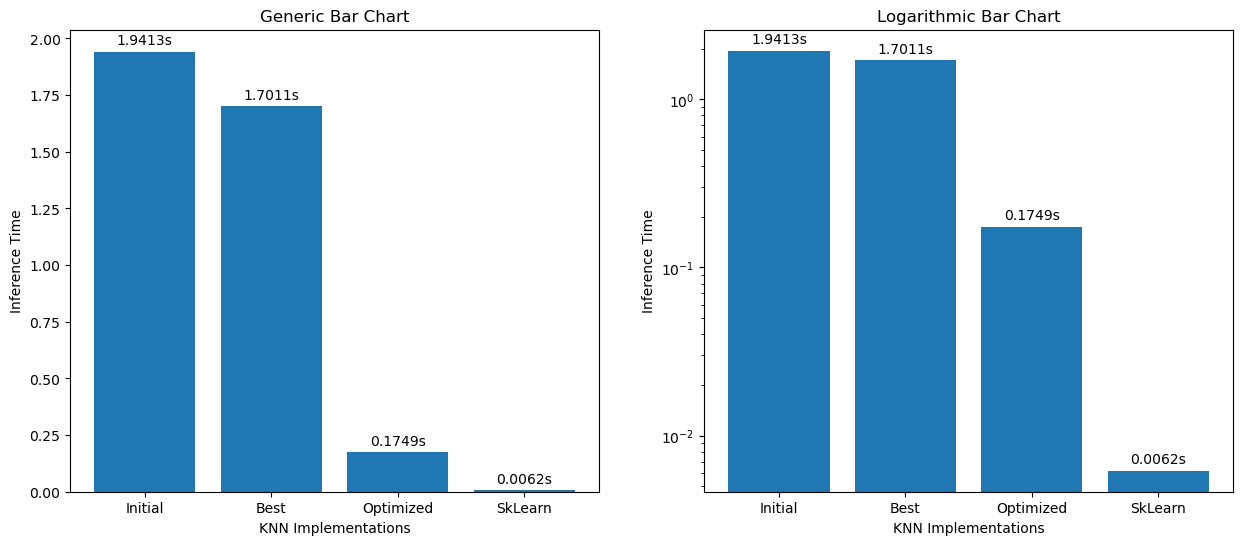

In [29]:
# plotting these times
knn_categories = ['Initial', 'Best', 'Optimized', 'SkLearn']
values = [init_knn_time, best_knn_time, opt_knn_time, sk_knn_time]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
 
# generic bar chart
bars = axes[0].bar(knn_categories, values)
for bar in bars:
    height = bar.get_height()
    axes[0].annotate(f'{height:.4f}s',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
axes[0].set_xlabel('KNN Implementations')
axes[0].set_ylabel('Inference Time')
axes[0].set_title('Generic Bar Chart')


# Loga bar chart
# generic bar chart
bars = axes[1].bar(knn_categories, values)
for bar in bars:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}s',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
axes[1].set_xlabel('KNN Implementations')
axes[1].set_ylabel('Inference Time')
axes[1].set_title('Logarithmic Bar Chart')
axes[1].set_yscale('log')

plt.show()

### 3 - Comparing inference times for different dataset sizes

In [45]:
dataset_steps = np.linspace(100, pictionary_data.shape[0], num=29, endpoint=True, dtype=int)

init_knn_times = []
best_knn_times = []
opt_knn_times = []
sk_knn_times = []

for data_size in dataset_steps:
    cur_dataset = pictionary_data[:data_size]
    
    # Initial KNN computation
    myInitKNN = KNN(dataset = cur_dataset)
    start_time = time.time()
    accuracy, precision, recall, f1 = myInitKNN.run()
    end_time = time.time()
    init_knn_time = end_time - start_time
    
    init_knn_times.append(init_knn_time)
    
    # Best KNN computation    
    myBestKNN = KNN(k = 10, encoding = 2, dist_metric = 'manhattan', dataset = cur_dataset)
    start_time = time.time()
    accuracy, precision, recall, f1 = myBestKNN.run()
    end_time = time.time()
    best_knn_time = end_time - start_time
    
    best_knn_times.append(best_knn_time)
    
    # Optimal KNN computation
    myOptKNN = optKNN(k = 10, encoding = 2, dist_metric = 'manhattan', dataset = cur_dataset)
    start_time = time.time()
    accuracy, precision, recall, f1 = myOptKNN.run()
    end_time = time.time()
    opt_knn_time = end_time - start_time

    opt_knn_times.append(opt_knn_time)
    
    # sklearn KNN computation
    skKNN = KNeighborsClassifier(n_neighbors=3)
    train_encodings = myOptKNN.train_encodings
    train_labels = myOptKNN.train_labels
    test_labels = myOptKNN.test_labels
    test_encodings = myOptKNN.test_encodings
    skKNN.fit(train_encodings, train_labels)
    start_time = time.time()
    predicted_labels = skKNN.predict(test_encodings)
    end_time = time.time()
    sk_knn_time = end_time - start_time
    
    sk_knn_times.append(sk_knn_time)
    
    print(".", end ="")
print()

.............................


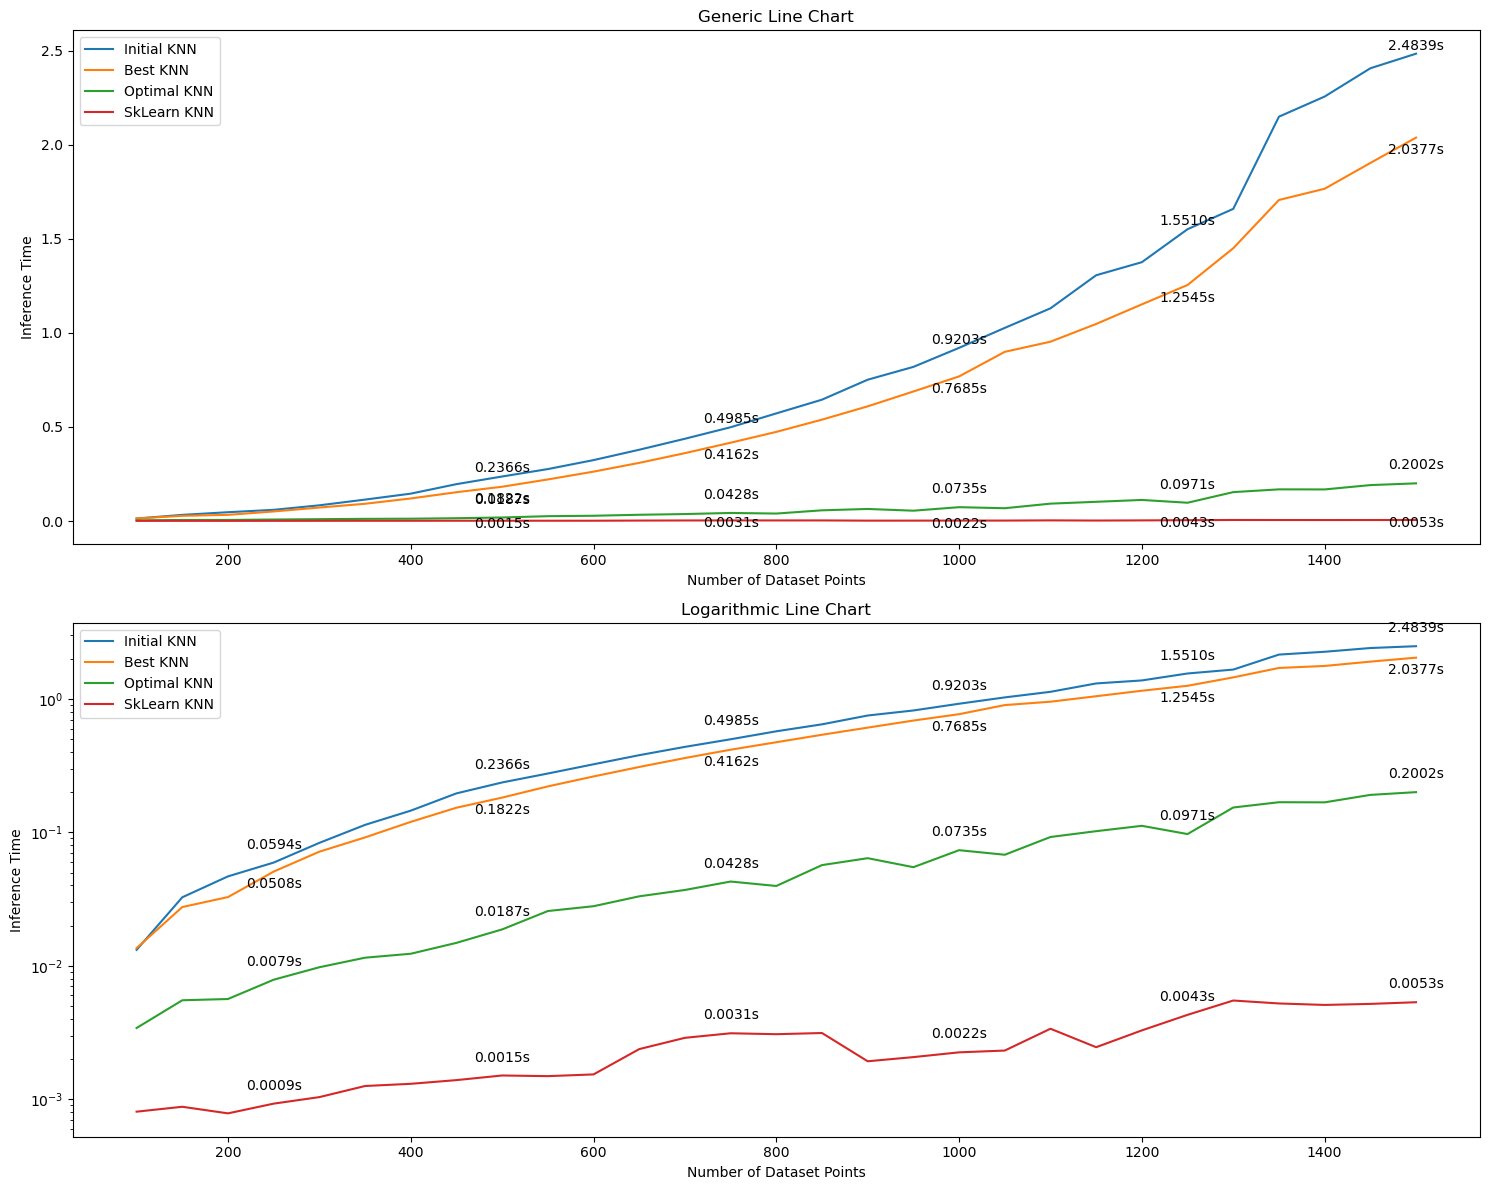

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

axes[0].plot(dataset_steps, init_knn_times, label='Initial KNN')
axes[0].plot(dataset_steps, best_knn_times, label='Best KNN')
axes[0].plot(dataset_steps, opt_knn_times, label='Optimal KNN')
axes[0].plot(dataset_steps, sk_knn_times, label='SkLearn KNN')
axes[0].set_xlabel('Number of Dataset Points')
axes[0].set_ylabel('Inference Time')
axes[0].set_title('Generic Line Chart')
axes[0].legend()

for i in range(len(dataset_steps)):
    if ((i+2)%5 == 0 and i > 5):
        axes[0].annotate(f'{init_knn_times[i]:.4f}s', xy=(dataset_steps[i], init_knn_times[i]),
                     textcoords="offset points", xytext=(0,3), ha='center')
        axes[0].annotate(f'{best_knn_times[i]:.4f}s', xy=(dataset_steps[i], best_knn_times[i]),
                     textcoords="offset points", xytext=(0,-12), ha='center')
        axes[0].annotate(f'{opt_knn_times[i]:.4f}s', xy=(dataset_steps[i], opt_knn_times[i]),
                        textcoords="offset points", xytext=(0,10), ha='center')
        axes[0].annotate(f'{sk_knn_times[i]:.4f}s', xy=(dataset_steps[i], sk_knn_times[i]),
                        textcoords="offset points", xytext=(0,-5), ha='center')

axes[1].plot(dataset_steps, init_knn_times, label='Initial KNN')
axes[1].plot(dataset_steps, best_knn_times, label='Best KNN')
axes[1].plot(dataset_steps, opt_knn_times, label='Optimal KNN')
axes[1].plot(dataset_steps, sk_knn_times, label='SkLearn KNN')
axes[1].set_xlabel('Number of Dataset Points')
axes[1].set_ylabel('Inference Time')
axes[1].set_title('Logarithmic Line Chart')
axes[1].set_yscale('log')
axes[1].legend()

for i in range(len(dataset_steps)):
    if ((i+2)%5 == 0):
        axes[1].annotate(f'{init_knn_times[i]:.4f}s', xy=(dataset_steps[i], init_knn_times[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
        axes[1].annotate(f'{best_knn_times[i]:.4f}s', xy=(dataset_steps[i], best_knn_times[i]),
                     textcoords="offset points", xytext=(0,-12), ha='center')
        axes[1].annotate(f'{opt_knn_times[i]:.4f}s', xy=(dataset_steps[i], opt_knn_times[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
        axes[1].annotate(f'{sk_knn_times[i]:.4f}s', xy=(dataset_steps[i], sk_knn_times[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

---



# 3 Decision Trees

## 3.1 Data Preprocessing and Exploration  

In [51]:
import pandas as pd

In [52]:
adv_data = pd.read_csv('../advertisement.csv')
adv_data.dtypes

age                   int64
gender               object
income              float64
education            object
married                bool
children              int64
city                 object
occupation           object
purchase_amount     float64
most bought item     object
labels               object
dtype: object

In [53]:
adv_data

age  gender        income    education  married  children           city  \
0     45    Male  61271.953359       Master    False         3    Lake Sheila   
1     24  Female  53229.101074  High School    False         1   Crystalburgh   
2     45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3     19    Male  48950.246384          PhD    False         0  Williamshaven   
4     29  Female  44792.627094       Master    False         0       New Paul   
..   ...     ...           ...          ...      ...       ...            ...   
995   61    Male  34246.773063       Master     True         3      Solisfurt   
996   56  Female  45494.225591     Bachelor    False         0    Dawsonmouth   
997   64  Female  68740.442006          PhD     True         0  Lake Garyport   
998   18  Female  44348.446680     Bachelor     True         0       Ericfurt   
999   61    Male  39160.083677       Master    False         0      Port Jose   

      occupation  purchase_amount most bought item  \
0         Doctor        87.697118          monitor   
1    Businessman       115.135586         lipstick   
2       Engineer       101.694559         biscuits   
3         Lawyer        97.964887            maggi   
4    Businessman        86.847281           carpet   
..           ...              ...              ...   
995           HR       103.357441              bed   
996     Engineer        85.159023         biscuits   
997     Salesman       101.434650              bat   
998      Retired        97.649988          perfume   
999    Housewife       105.591485            shirt   

                               labels  
0         electronics clothing sports  
1                    furniture beauty  
2    clothing electronics food sports  
3                                food  
4                                home  
..                                ...  
995                    food furniture  
996                home clothing food  
997                   sports clothing  
998                            beauty  
999                    books clothing  

[1000 rows x 11 columns]

In [54]:
# Converting labels to list and sorting them
adv_data['labels'] = adv_data['labels'].str.split(' ')
adv_data

age  gender        income    education  married  children           city  \
0     45    Male  61271.953359       Master    False         3    Lake Sheila   
1     24  Female  53229.101074  High School    False         1   Crystalburgh   
2     45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3     19    Male  48950.246384          PhD    False         0  Williamshaven   
4     29  Female  44792.627094       Master    False         0       New Paul   
..   ...     ...           ...          ...      ...       ...            ...   
995   61    Male  34246.773063       Master     True         3      Solisfurt   
996   56  Female  45494.225591     Bachelor    False         0    Dawsonmouth   
997   64  Female  68740.442006          PhD     True         0  Lake Garyport   
998   18  Female  44348.446680     Bachelor     True         0       Ericfurt   
999   61    Male  39160.083677       Master    False         0      Port Jose   

      occupation  purchase_amount most bought item  \
0         Doctor        87.697118          monitor   
1    Businessman       115.135586         lipstick   
2       Engineer       101.694559         biscuits   
3         Lawyer        97.964887            maggi   
4    Businessman        86.847281           carpet   
..           ...              ...              ...   
995           HR       103.357441              bed   
996     Engineer        85.159023         biscuits   
997     Salesman       101.434650              bat   
998      Retired        97.649988          perfume   
999    Housewife       105.591485            shirt   

                                    labels  
0          [electronics, clothing, sports]  
1                      [furniture, beauty]  
2    [clothing, electronics, food, sports]  
3                                   [food]  
4                                   [home]  
..                                     ...  
995                      [food, furniture]  
996                 [home, clothing, food]  
997                     [sports, clothing]  
998                               [beauty]  
999                      [books, clothing]  

[1000 rows x 11 columns]

In [55]:
# Getting all unique labels
all_labels = adv_data['labels'].explode() # explode taken from chatGPT
unique_labels, label_frequencies = np.unique(all_labels, return_counts=True)
unique_labels

array(['beauty', 'books', 'clothing', 'electronics', 'food', 'furniture',
       'home', 'sports'], dtype=object)

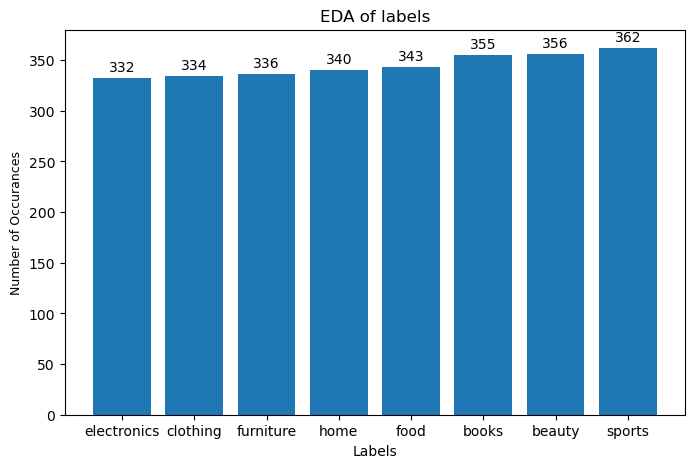

In [56]:
# sorting by frequencies
sorted_indices = np.argsort(label_frequencies)
unique_labels = unique_labels[sorted_indices]
label_frequencies = label_frequencies[sorted_indices]

fig, axes = plt.subplots(figsize=(8, 5))
plt.xlabel('Labels')
plt.ylabel('Number of Occurances', fontsize=9)
plt.title('EDA of labels')

bars = axes.bar(unique_labels, label_frequencies)

for bar in bars:
    height = bar.get_height()
    axes.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.show()

We notice that the distribution of individual labels are nicely distributed.

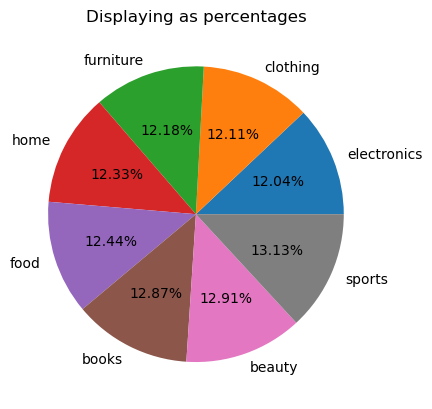

In [57]:
plt.title("Displaying as percentages")
plt.pie(label_frequencies, labels=unique_labels, autopct='%.2f%%')
plt.show()

Checking occurances of individual lists in the labels columns

In [58]:
labels = adv_data['labels']

def sort_func(cur_list):
    sorted_list = sorted(cur_list)
    return ' '.join(sorted_list)

all_labels = labels.apply(sort_func)

unique_labels, label_frequencies = np.unique(all_labels, return_counts=True)
    
sorted_indices = np.argsort(label_frequencies)
unique_labels = unique_labels[sorted_indices]
label_frequencies = label_frequencies[sorted_indices]

for i in range(len(unique_labels)):
    print(unique_labels[i], ":", label_frequencies[i])

beauty books clothing food furniture home : 1
beauty books clothing food furniture home sports : 1
beauty books clothing food furniture sports : 1
beauty books clothing food home sports : 1
clothing food home sports : 1
clothing food furniture home : 1
clothing electronics food furniture sports : 1
books food furniture home : 1
books food furniture home sports : 1
beauty books clothing furniture sports : 1
beauty books electronics food furniture home : 1
beauty books electronics food home : 1
beauty books electronics food home sports : 1
books electronics furniture home : 1
books electronics furniture home sports : 1
books clothing food home sports : 1
books clothing food sports : 1
books clothing furniture sports : 1
beauty books electronics food sports : 1
beauty books electronics furniture home sports : 1
books clothing electronics food sports : 1
books clothing electronics home sports : 1
books clothing electronics food furniture : 1
books clothing electronics food furniture home :


We see that 

    despite indiviudal labels being uniformly distributed, the lists of labels aren't distributed uniformly.



In [59]:
def categorical_chart(current_label, width = 6, height = 4):
    all_labels = adv_data[current_label]
    unique_labels, label_frequencies = np.unique(all_labels, return_counts=True)
    
    sorted_indices = np.argsort(label_frequencies)
    unique_labels = unique_labels[sorted_indices]
    label_frequencies = label_frequencies[sorted_indices]

    fig, axes = plt.subplots(figsize=(width, height))
    plt.xlabel(current_label)
    plt.ylabel('Number of Occurances', fontsize=9)
    plt.title('EDA of labels')

    bars = axes.bar(unique_labels, label_frequencies)

    for bar in bars:
        height = bar.get_height()
        axes.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()

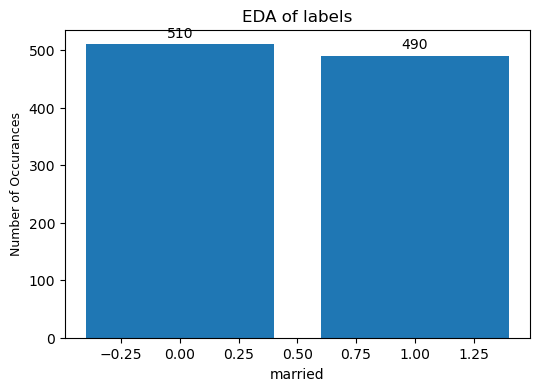

In [60]:
# EDA of Married
categorical_chart('married')

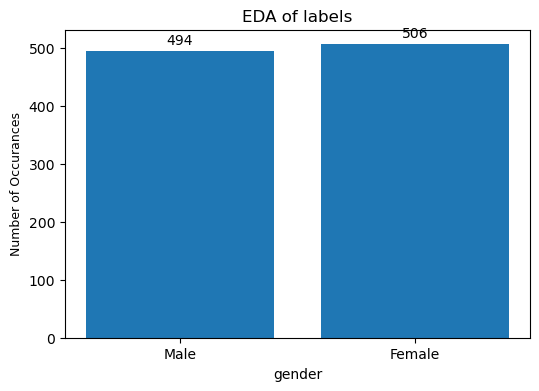

In [61]:
# EDA of gender
categorical_chart('gender')

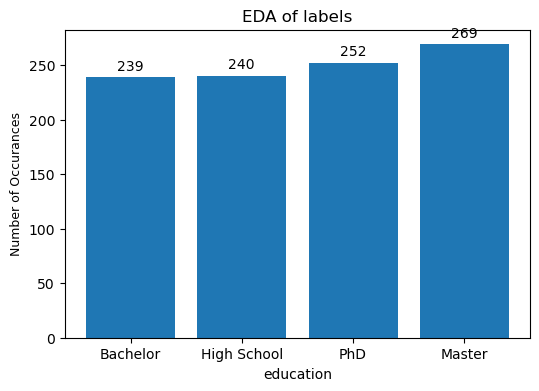

In [62]:
# EDA of education
categorical_chart('education')

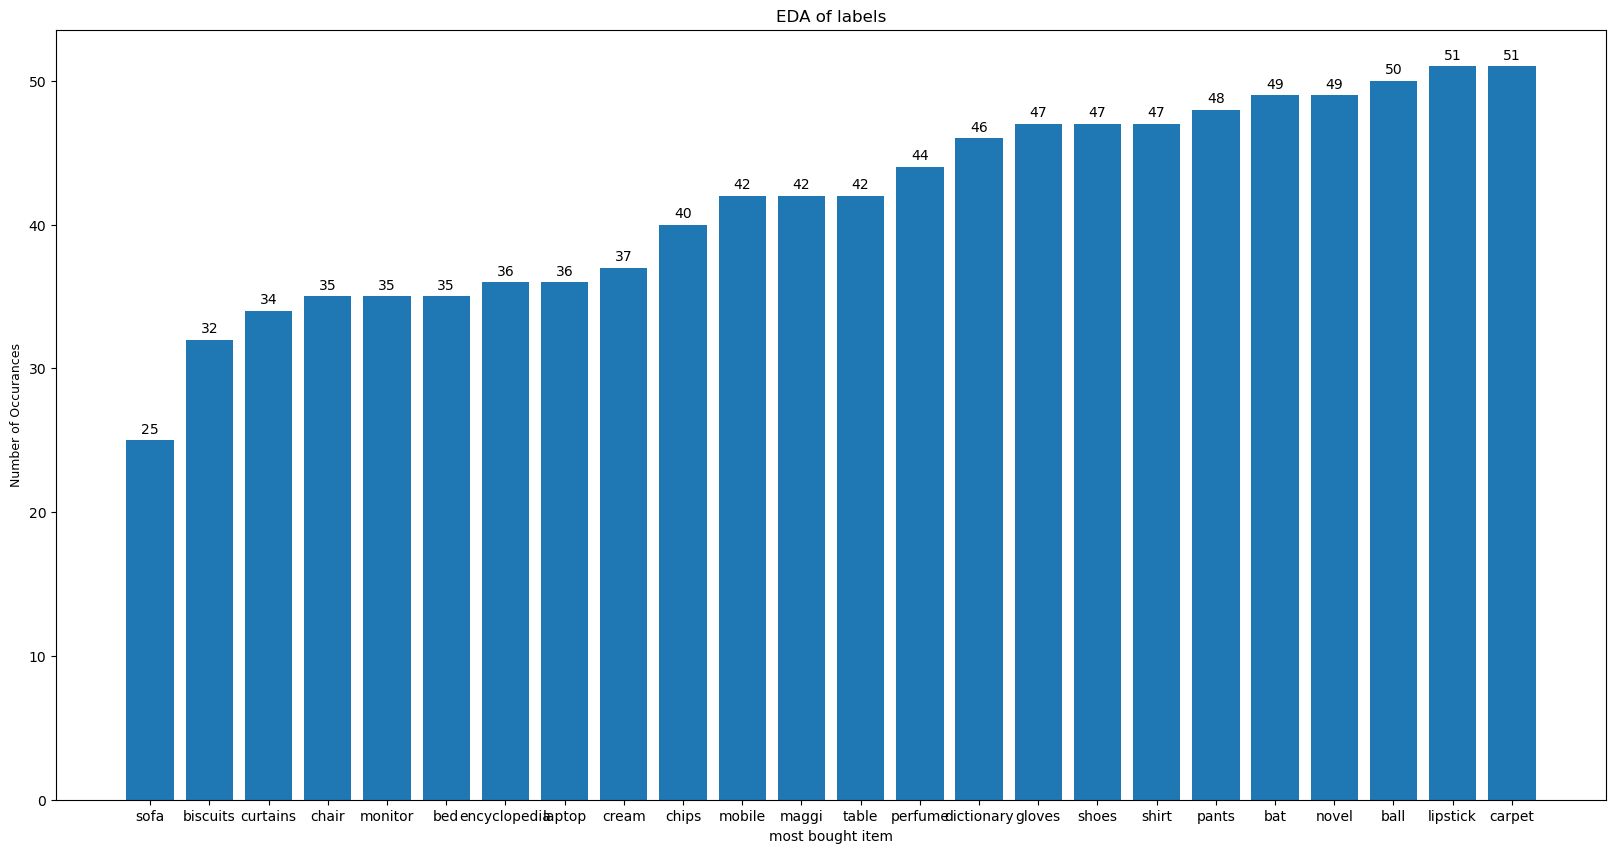

In [63]:
# EDA of most bought item
categorical_chart('most bought item', 20, 10)

## 3.2 Preprocessing

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from pprint import pprint
from itertools import chain, combinations
from tabulate import tabulate

## 3.3 Multilabel Classification

### Powerset Formulation

In [71]:
'''
    Powerset Decision Tree class
'''

# Powerset class with one hot encoding for features
class OHPowersetDT:
    # function to run and report metrics
    def run(self):
        y_pred = self.dec_tree.predict(self.X_val)
        
        # function to get mlb from y_pred and y_val
        enencoded_y = []
        for row in self.y:
            cur_enc = self.ohe_to_enc[np.where(row == 1)[0][0]]
            cur_list = self.enc_to_labels[cur_enc].split()
            enencoded_y.append(cur_list)
        label_mlb = MultiLabelBinarizer()
        label_mlb.fit(enencoded_y)
        
        mlb_y_pred, mlb_y_val = [], []
        
        for i in range(len(y_pred)):
            cur_pos = np.where(y_pred[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_pred.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_pred.append(cur_mlb)
                
        for i in range(len(self.y_val)):
            cur_pos = np.where(self.y_val[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_val.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_val.append(cur_mlb)
                
        mlb_y_pred = np.array(mlb_y_pred)
        mlb_y_val = np.array(mlb_y_val)
        
        
        hamming_l = hamming_loss(mlb_y_val, mlb_y_pred)
        accuracy = accuracy_score(mlb_y_val, mlb_y_pred)
        precision = precision_score(mlb_y_val, mlb_y_pred, average='micro')
        recall = recall_score(mlb_y_val, mlb_y_pred, average='micro')
        f1_micro = f1_score(mlb_y_val, mlb_y_pred, average='micro')
        f1_macro = f1_score(mlb_y_val, mlb_y_pred, average='macro')
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(mlb_y_val, mlb_y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
        self.dec_tree.fit(self.X_train, self.y_train)
    
    # function to split the dataset into train and validation
    def split_data(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, test_size=self.split/100, random_state=42)
    
    # functions to do data preprocessing
    def feature_preprocessing(self):
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns

        # converting features to one hot encoding
        column_trans = make_column_transformer(
            (OneHotEncoder(), categorical_columns),
            remainder = 'passthrough'
        )
        self.X = column_trans.fit_transform(self.data)
    
    def labels_preprocessing(self):        
        unique_labels = self.unique_labels
        
        # transforming into labels into powerset encoding
        def powerset(input_list):
            s = list(input_list)
            return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
        powerset_labels = powerset(unique_labels)

        cur_ordinal = 1
        powerset_dict = {}
        for label_set in powerset_labels:
            label_sort = sorted(label_set)
            cur_heading = ' '.join(label_set)
            powerset_dict[cur_heading] = str(cur_ordinal)  
            cur_ordinal += 1

        def label_sets(labels_list):
            cur_list = sorted(labels_list)
            return powerset_dict[' '.join(cur_list)]

        self.labels = self.labels.apply(label_sets)
        unique_powerset_labels = self.labels.unique()
        
        self.enc_to_labels = {}                
        for enc in unique_powerset_labels:
            for lists in powerset_dict:
                if (powerset_dict[lists] == enc):
                    self.enc_to_labels[enc] = lists
        
        # unique_powerset_labels
        self.labels = self.labels.to_numpy().reshape(-1, 1)

        label_encoder = OneHotEncoder(sparse_output = False)
        self.y = label_encoder.fit_transform(self.labels)
        
        self.ohe_to_enc = {}
        for enc in unique_powerset_labels:
            cur_ohe = label_encoder.transform([[enc]])
            self.ohe_to_enc[np.where(cur_ohe[0] == 1)[0][0]] = enc

            
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', split = 20, dataset = adv_data):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.split = split
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        self.split_data()
        
        # training the tree
        self.train()


# Powerset class with LabelEncoder for input features
class PowersetDT:
    # function to run and report metrics
    def run(self):
        y_pred = self.dec_tree.predict(self.X_val)
        
        # function to get mlb from y_pred and y_val
        enencoded_y = []
        for row in self.y:
            cur_enc = self.ohe_to_enc[np.where(row == 1)[0][0]]
            cur_list = self.enc_to_labels[cur_enc].split()
            enencoded_y.append(cur_list)
        label_mlb = MultiLabelBinarizer()
        label_mlb.fit(enencoded_y)
        
        mlb_y_pred, mlb_y_val = [], []
        
        for i in range(len(y_pred)):
            cur_pos = np.where(y_pred[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_pred.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_pred.append(cur_mlb)
                
        for i in range(len(self.y_val)):
            cur_pos = np.where(self.y_val[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_val.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_val.append(cur_mlb)
                
        mlb_y_pred = np.array(mlb_y_pred)
        mlb_y_val = np.array(mlb_y_val)
        
        
        hamming_l = hamming_loss(mlb_y_val, mlb_y_pred)
        accuracy = accuracy_score(mlb_y_val, mlb_y_pred)
        precision = precision_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        recall = recall_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        f1_micro = f1_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        f1_macro = f1_score(mlb_y_val, mlb_y_pred, average='macro', zero_division = 0)
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(mlb_y_val, mlb_y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
        self.dec_tree.fit(self.X_train, self.y_train)
    
    # function to split the dataset into train and validation
    def split_data(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, test_size=self.split/100, random_state=42)
    
    # functions to do data preprocessing
    def feature_preprocessing(self):
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
        
        for column in categorical_columns:
            encoder = LabelEncoder()
            self.data[column] = encoder.fit_transform(self.data[column])
            
        self.X = self.data
    
    def labels_preprocessing(self):        
        unique_labels = self.unique_labels
        
        # transforming into labels into powerset encoding
        def powerset(input_list):
            s = list(input_list)
            return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
        powerset_labels = powerset(unique_labels)

        cur_ordinal = 1
        powerset_dict = {}
        for label_set in powerset_labels:
            label_sort = sorted(label_set)
            cur_heading = ' '.join(label_set)
            powerset_dict[cur_heading] = str(cur_ordinal)  
            cur_ordinal += 1

        def label_sets(labels_list):
            cur_list = sorted(labels_list)
            return powerset_dict[' '.join(cur_list)]

        self.labels = self.labels.apply(label_sets)
        unique_powerset_labels = self.labels.unique()
        
        self.enc_to_labels = {}                
        for enc in unique_powerset_labels:
            for lists in powerset_dict:
                if (powerset_dict[lists] == enc):
                    self.enc_to_labels[enc] = lists
        
        # unique_powerset_labels
        self.labels = self.labels.to_numpy().reshape(-1, 1)

        label_encoder = OneHotEncoder(sparse_output = False)
        self.y = label_encoder.fit_transform(self.labels)
        
        self.ohe_to_enc = {}
        for enc in unique_powerset_labels:
            cur_ohe = label_encoder.transform([[enc]])
            self.ohe_to_enc[np.where(cur_ohe[0] == 1)[0][0]] = enc

            
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', split = 20, dataset = adv_data):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.split = split
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        self.split_data()
        
        # training the tree
        self.train()


	 --- General Metrics ---
Hamming Loss: 0.32687500
Accuracy: 0.02000000
F1 Micro: 0.52497729
F1 Macro: 0.52440668
Precision: 0.50348432
Recall: 0.54838710

	 --- Combined Confusion Matrix ---


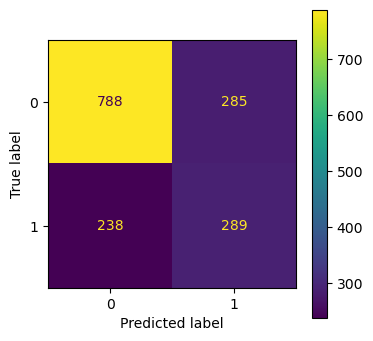


	 --- Class Wise Confusion Matrices ---


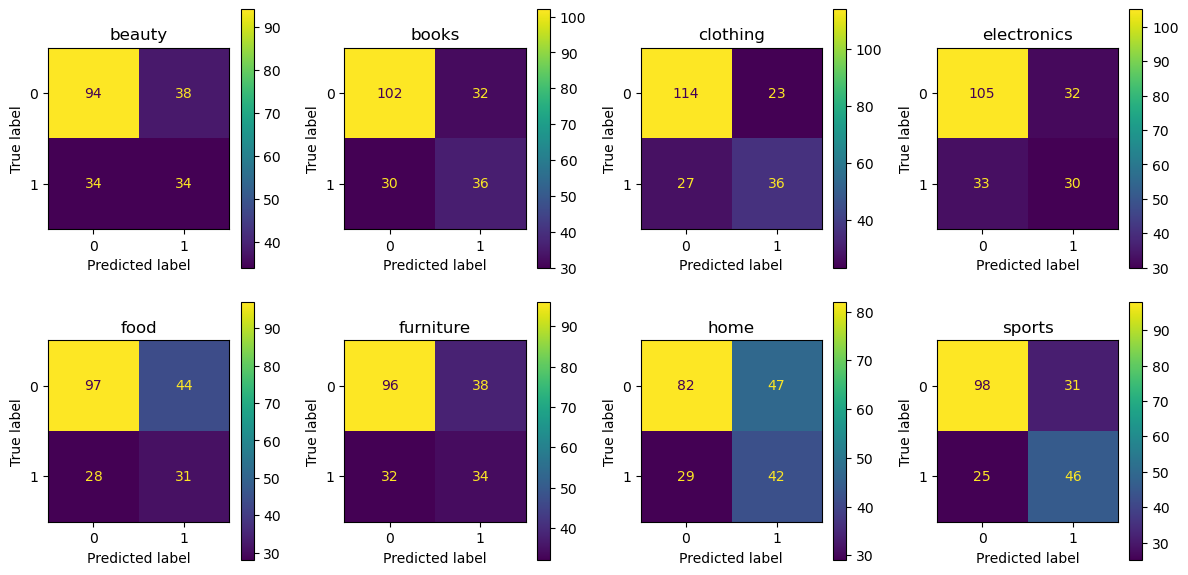

In [72]:
#Dummy run 
myDT = PowersetDT(max_depth = 30, max_features = 11, criterion = 'gini')
returned_metrics = myDT.run()

print("\n\t --- General Metrics ---")

print(f'Hamming Loss: {returned_metrics[0]:.8f}')
print(f'Accuracy: {returned_metrics[1]:.8f}')
print(f'F1 Micro: {returned_metrics[2]:.8f}')
print(f'F1 Macro: {returned_metrics[3]:.8f}')
print(f'Precision: {returned_metrics[5]:.8f}')
print(f'Recall: {returned_metrics[6]:.8f}')

confusion_matrices = returned_metrics[4]
returned_classes = returned_metrics[7]

print("\n\t --- Combined Confusion Matrix ---")

combined_matrix = np.sum(confusion_matrices, axis = 0)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix)
disp.plot(ax = axes)
plt.show()

print("\n\t --- Class Wise Confusion Matrices ---")


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[i])
    disp.plot(ax = axes[0][i])
    axes[0][i].set_title(returned_classes[i])
    
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[4+i])
    disp.plot(ax = axes[1][i])
    axes[1][i].set_title(returned_classes[4+i])

plt.tight_layout()
plt.show()

In [73]:
'''
    Multioutput Decision Tree class
'''
# formulation where we use one hot encoding to encode input features
class OHMultiDT:
    # function to run and report metrics
    def run(self):
        y_pred = self.dec_tree.predict(self.X_val)
        
        hamming_l = hamming_loss(self.y_val, y_pred)
        accuracy = accuracy_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred, average='micro')
        recall = recall_score(self.y_val, y_pred, average='micro')
        f1_micro = f1_score(self.y_val, y_pred, average='micro')
        f1_macro = f1_score(self.y_val, y_pred, average='macro')
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(self.y_val, y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, self.label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
        self.dec_tree.fit(self.X_train, self.y_train)
    
    # function to split the dataset into train and validation
    def split_data(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, test_size=self.split/100, random_state=42)
    
    # functions to do data preprocessing
    def feature_preprocessing(self):        
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns

        # converting features to one hot encoding
        column_trans = make_column_transformer(
            (OneHotEncoder(sparse_output=False), categorical_columns),
            remainder = 'passthrough'
        )
        self.X = column_trans.fit_transform(self.data)
    
    def labels_preprocessing(self):        
        self.label_mlb = MultiLabelBinarizer()
        self.y = self.label_mlb.fit_transform(self.labels)
    
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', split = 20, dataset = adv_data):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.split = split
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        self.split_data()
        
        # training the tree
        self.train()
        
# formulation where we use LabelEncoder() to encode input features
class MultiDT:
    # function to run and report metrics
    def run(self):
        y_pred = self.dec_tree.predict(self.X_val)
        
        hamming_l = hamming_loss(self.y_val, y_pred)
        accuracy = accuracy_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred, average='micro', zero_division = 0)
        recall = recall_score(self.y_val, y_pred, average='micro', zero_division = 0)
        f1_micro = f1_score(self.y_val, y_pred, average='micro', zero_division = 0)
        f1_macro = f1_score(self.y_val, y_pred, average='macro', zero_division = 0)
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(self.y_val, y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, self.label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
        self.dec_tree.fit(self.X_train, self.y_train)
    
    # function to split the dataset into train and validation
    def split_data(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, test_size=self.split/100, random_state=42)
    
    # functions to do data preprocessing
    def feature_preprocessing(self):        
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns

        for column in categorical_columns:
            encoder = LabelEncoder()
            self.data[column] = encoder.fit_transform(self.data[column])
            
        self.X = self.data
    
    def labels_preprocessing(self):        
        self.label_mlb = MultiLabelBinarizer()
        self.y = self.label_mlb.fit_transform(self.labels)
    
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', split = 20, dataset = adv_data):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.split = split
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        self.split_data()
        
        # training the tree
        self.train()


	 --- General Metrics ---
Hamming Loss: 0.27750000
Accuracy: 0.05000000
F1 Micro: 0.52966102
F1 Macro: 0.52559881
Precision: 0.59952038
Recall: 0.47438330

	 --- Combined Confusion Matrix ---


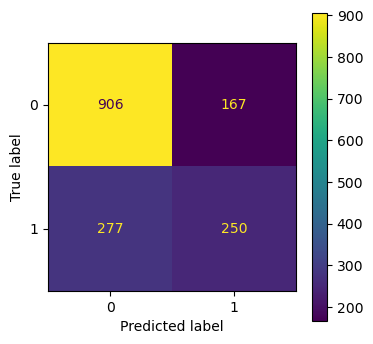


	 --- Class Wise Confusion Matrices ---


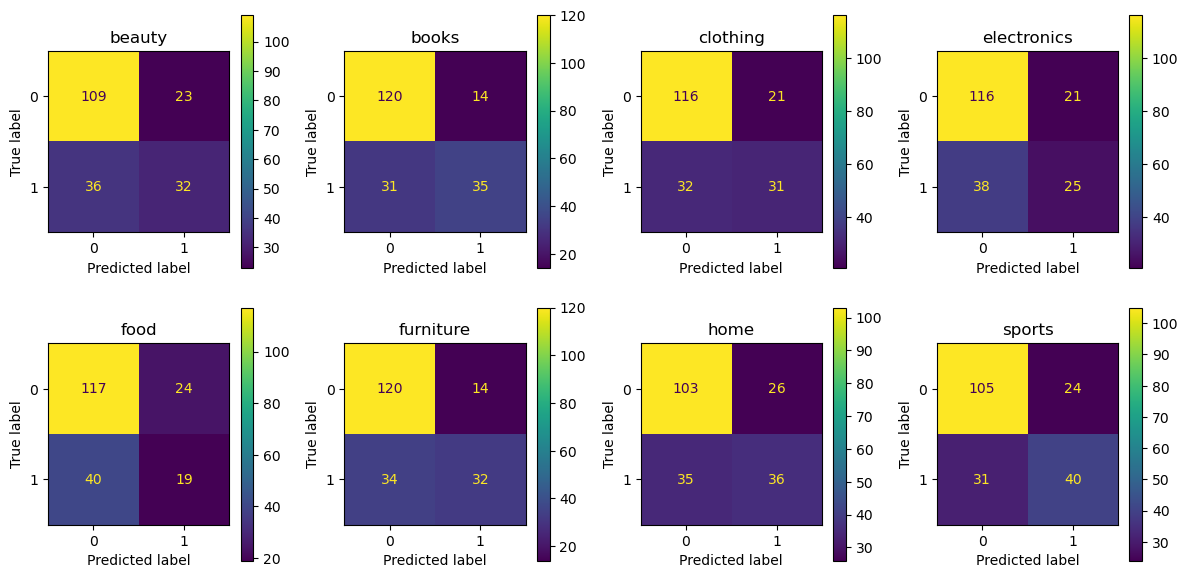

In [74]:
#Dummy run 
myDT = MultiDT(max_depth = 10, max_features = 11, criterion = 'gini')
returned_metrics = myDT.run()

print("\n\t --- General Metrics ---")

print(f'Hamming Loss: {returned_metrics[0]:.8f}')
print(f'Accuracy: {returned_metrics[1]:.8f}')
print(f'F1 Micro: {returned_metrics[2]:.8f}')
print(f'F1 Macro: {returned_metrics[3]:.8f}')
print(f'Precision: {returned_metrics[5]:.8f}')
print(f'Recall: {returned_metrics[6]:.8f}')

confusion_matrices = returned_metrics[4]
returned_classes = returned_metrics[7]

print("\n\t --- Combined Confusion Matrix ---")

combined_matrix = np.sum(confusion_matrices, axis = 0)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix)
disp.plot(ax = axes)
plt.show()

print("\n\t --- Class Wise Confusion Matrices ---")


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[i])
    disp.plot(ax = axes[0][i])
    axes[0][i].set_title(returned_classes[i])
    
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[4+i])
    disp.plot(ax = axes[1][i])
    axes[1][i].set_title(returned_classes[4+i])

plt.tight_layout()
plt.show()

## 3.4 Hyperparameter Tuning

### 3.4.1 Tasks

### 1 - Reporting Metrics for all possible combination of inputs

We sort them by F1 (Micro) as the labels in the output features are balanced.

### Powerset Formulation

In [75]:
criterion_list = ['gini', 'entropy']
max_depth_list = [3,5,10,20,30]
max_features_list = [3,5,7,9,11]

In [88]:
# Powerset formulation
pw_table = []

for cur_criterion in criterion_list:
    for depth in max_depth_list:
        for num_features in max_features_list:
            myDT = PowersetDT(max_depth = depth, max_features = num_features, criterion = cur_criterion)
            returned_metrics = myDT.run()
            
            print(".", end = "")
            
            hamming_l = returned_metrics[0]
            accuracy = returned_metrics[1]
            f1_micro = returned_metrics[2]
            f1_macro = returned_metrics[3]
            confusion_matrices = returned_metrics[4]
            precision = returned_metrics[5]
            recall = returned_metrics[6]
            
            combined_matrix = np.sum(confusion_matrices, axis = 0)
            
            pw_table.append([cur_criterion, depth, num_features, hamming_l, accuracy, f1_micro, f1_macro, precision, recall, combined_matrix])
            
print()

..................................................


In [89]:
pw_table = sorted(pw_table, key=lambda x: x[5], reverse = True)

table_headers = ['Crit.', 'MaxD', 'MaxF', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.', 'Conf.M.']
print(tabulate(pw_table, table_headers, tablefmt="grid"))

+---------+--------+--------+----------+--------+-------------+-------------+----------+------------+---------------+
| Crit.   |   MaxD |   MaxF |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) |    Prec. |       Rec. | Conf.M.       |
+=========+========+========+==========+========+=============+=============+==========+============+===============+
| gini    |     20 |     11 | 0.320625 |  0.025 |  0.533212   |  0.532625   | 0.512238 | 0.555977   | [[794 279]    |
|         |        |        |          |        |             |             |          |            |  [234 293]]   |
+---------+--------+--------+----------+--------+-------------+-------------+----------+------------+---------------+
| entropy |     20 |      9 | 0.3225   |  0.035 |  0.532609   |  0.528893   | 0.509532 | 0.557875   | [[790 283]    |
|         |        |        |          |        |             |             |          |            |  [233 294]]   |
+---------+--------+--------+----------+--------+-------

### Multioutput formulation

In [90]:
# Multioutput formulation
mo_table = []

for cur_criterion in criterion_list:
    for depth in max_depth_list:
        for num_features in max_features_list:
            myDT = MultiDT(max_depth = depth, max_features = num_features, criterion = cur_criterion)
            returned_metrics = myDT.run()
            
            print(".", end = "")
            
            hamming_l = returned_metrics[0]
            accuracy = returned_metrics[1]
            f1_micro = returned_metrics[2]
            f1_macro = returned_metrics[3]
            confusion_matrices = returned_metrics[4]
            precision = returned_metrics[5]
            recall = returned_metrics[6]
            
            combined_matrix = np.sum(confusion_matrices, axis = 0)
            
            mo_table.append([cur_criterion, depth, num_features, hamming_l, accuracy, f1_micro, f1_macro, precision, recall, combined_matrix])
            
print()

..................................................


In [91]:
mo_table = sorted(mo_table, key=lambda x: x[5], reverse = True)

table_headers = ['Crit.', 'MaxD', 'MaxF', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.', 'Conf.M.']
print(tabulate(mo_table, table_headers, tablefmt="grid"))

+---------+--------+--------+----------+--------+-------------+-------------+----------+------------+---------------+
| Crit.   |   MaxD |   MaxF |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) |    Prec. |       Rec. | Conf.M.       |
+=========+========+========+==========+========+=============+=============+==========+============+===============+
| gini    |     10 |      9 | 0.276875 |  0.075 |  0.543769   |  0.542531   | 0.594595 | 0.500949   | [[893 180]    |
|         |        |        |          |        |             |             |          |            |  [263 264]]   |
+---------+--------+--------+----------+--------+-------------+-------------+----------+------------+---------------+
| entropy |     30 |      7 | 0.311875 |  0.04  |  0.533209   |  0.530625   | 0.52583  | 0.540797   | [[816 257]    |
|         |        |        |          |        |             |             |          |            |  [242 285]]   |
+---------+--------+--------+----------+--------+-------

### 2 - For both of them also rank the top 3 performing set of hyperparamters according to F1 score

### Powerset Formulation

In [94]:
pw_table = pw_table[:3]

table_headers = ['Crit.', 'MaxD', 'MaxF', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.', 'Conf.M']
print(tabulate(pw_table, table_headers, tablefmt="grid"))

+---------+--------+--------+----------+--------+-------------+-------------+----------+----------+-------------+
| Crit.   |   MaxD |   MaxF |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) |    Prec. |     Rec. | Conf.M      |
+=========+========+========+==========+========+=============+=============+==========+==========+=============+
| gini    |     20 |     11 | 0.320625 |  0.025 |    0.533212 |    0.532625 | 0.512238 | 0.555977 | [[794 279]  |
|         |        |        |          |        |             |             |          |          |  [234 293]] |
+---------+--------+--------+----------+--------+-------------+-------------+----------+----------+-------------+
| entropy |     20 |      9 | 0.3225   |  0.035 |    0.532609 |    0.528893 | 0.509532 | 0.557875 | [[790 283]  |
|         |        |        |          |        |             |             |          |          |  [233 294]] |
+---------+--------+--------+----------+--------+-------------+-------------+----------+

### Multioutput Formulation

In [95]:
mo_table = mo_table[:3]

table_headers = ['Crit.', 'MaxD', 'MaxF', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.', 'Conf.M']
print(tabulate(mo_table, table_headers, tablefmt="grid"))

+---------+--------+--------+----------+--------+-------------+-------------+----------+----------+-------------+
| Crit.   |   MaxD |   MaxF |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) |    Prec. |     Rec. | Conf.M      |
+=========+========+========+==========+========+=============+=============+==========+==========+=============+
| gini    |     10 |      9 | 0.276875 |  0.075 |    0.543769 |    0.542531 | 0.594595 | 0.500949 | [[893 180]  |
|         |        |        |          |        |             |             |          |          |  [263 264]] |
+---------+--------+--------+----------+--------+-------------+-------------+----------+----------+-------------+
| entropy |     30 |      7 | 0.311875 |  0.04  |    0.533209 |    0.530625 | 0.52583  | 0.540797 | [[816 257]  |
|         |        |        |          |        |             |             |          |          |  [242 285]] |
+---------+--------+--------+----------+--------+-------------+-------------+----------+

### 3 - K Fold Validation

In [96]:
from sklearn.model_selection import KFold

### Powerset Formulation

In [97]:
best_crit, best_depth, best_features = pw_table[0][0:3]
best_crit, best_depth, best_features

('gini', 20, 11)

In [98]:
'''
    K Fold Powerset Decision Tree class
'''
class KFoldPowersetDT:
    # function to run and report metrics
    def run(self, index):
        self.X_train, self.X_val, self.y_train, self.y_val = self.X_train_folds[index], self.X_val_folds[index], self.y_train_folds[index], self.y_val_folds[index] 
        self.dec_tree = self.trees[index]
                
        y_pred = self.dec_tree.predict(self.X_val)
        
        # function to get mlb from y_pred and y_val
        enencoded_y = []
        for row in self.y:
            cur_enc = self.ohe_to_enc[np.where(row == 1)[0][0]]
            cur_list = self.enc_to_labels[cur_enc].split()
            enencoded_y.append(cur_list)
        label_mlb = MultiLabelBinarizer()
        label_mlb.fit(enencoded_y)
        
        mlb_y_pred, mlb_y_val = [], []
        
        for i in range(len(y_pred)):
            cur_pos = np.where(y_pred[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_pred.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_pred.append(cur_mlb)
                
        for i in range(len(self.y_val)):
            cur_pos = np.where(self.y_val[i] == 1)[0]

            if (len(cur_pos) == 0):
                mlb_y_val.append([0]*8)
            else:
                cur_enc = self.ohe_to_enc[cur_pos[0]]
                cur_list = self.enc_to_labels[cur_enc].split()
                cur_mlb = label_mlb.transform([cur_list])[0]
                mlb_y_val.append(cur_mlb)
                
        mlb_y_pred = np.array(mlb_y_pred)
        mlb_y_val = np.array(mlb_y_val)
        
        
        hamming_l = hamming_loss(mlb_y_val, mlb_y_pred)
        accuracy = accuracy_score(mlb_y_val, mlb_y_pred)
        precision = precision_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        recall = recall_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        f1_micro = f1_score(mlb_y_val, mlb_y_pred, average='micro', zero_division = 0)
        f1_macro = f1_score(mlb_y_val, mlb_y_pred, average='macro', zero_division = 0)
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(mlb_y_val, mlb_y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.trees = []
        for i in range(self.k):
            self.X_train, self.y_train = self.X_train_folds[i], self.y_train_folds[i]
                        
            dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
            dec_tree.fit(self.X_train, self.y_train)
            
            self.trees.append(dec_tree)
        
    
    # functions to do data preprocessing
    def feature_preprocessing(self):
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns

        for column in categorical_columns:
            encoder = LabelEncoder()
            self.data[column] = encoder.fit_transform(self.data[column])
            
        self.X = self.data
    
    def labels_preprocessing(self):        
        unique_labels = self.unique_labels
        
        # transforming into labels into powerset encoding
        def powerset(input_list):
            s = list(input_list)
            return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
        powerset_labels = powerset(unique_labels)

        cur_ordinal = 1
        powerset_dict = {}
        for label_set in powerset_labels:
            label_sort = sorted(label_set)
            cur_heading = ' '.join(label_set)
            powerset_dict[cur_heading] = str(cur_ordinal)  
            cur_ordinal += 1

        def label_sets(labels_list):
            cur_list = sorted(labels_list)
            return powerset_dict[' '.join(cur_list)]

        self.labels = self.labels.apply(label_sets)
        unique_powerset_labels = self.labels.unique()
        
        self.enc_to_labels = {}                
        for enc in unique_powerset_labels:
            for lists in powerset_dict:
                if (powerset_dict[lists] == enc):
                    self.enc_to_labels[enc] = lists
        
        # unique_powerset_labels
        self.labels = self.labels.to_numpy().reshape(-1, 1)

        label_encoder = OneHotEncoder(sparse_output = False)
        self.y = label_encoder.fit_transform(self.labels)
        
        self.ohe_to_enc = {}
        for enc in unique_powerset_labels:
            cur_ohe = label_encoder.transform([[enc]])
            self.ohe_to_enc[np.where(cur_ohe[0] == 1)[0][0]] = enc

            
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', dataset = adv_data, k = 4):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.k = k
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        
        # K fold
        kf = KFold(n_splits=self.k, shuffle=True, random_state=42)

        self.X_train_folds = []
        self.X_val_folds = []
        self.y_train_folds = []
        self.y_val_folds = []
        
        # Split the data into K folds
        for train_indices, val_indices in kf.split(self.X):            
            X_train, X_val = self.X.iloc[train_indices], self.X.iloc[val_indices]
            y_train, y_val = self.y[train_indices], self.y[val_indices]
            
            self.X_train_folds.append(X_train)
            self.X_val_folds.append(X_val)
            self.y_train_folds.append(y_train)
            self.y_val_folds.append(y_val)
        
        # training the trees
        self.train()

In [99]:
for k_num in range(3, 7):
    print("\n\t --- Metrics for {}-Fold ---".format(k_num))
    
    myDT = KFoldPowersetDT(criterion = best_crit, max_depth = best_depth, max_features = best_features, k = k_num)

    pw_k_table = []
    for i in range(k_num):
        returned_metrics = myDT.run(i)

        hamming_l = returned_metrics[0]
        accuracy = returned_metrics[1]
        f1_micro = returned_metrics[2]
        f1_macro = returned_metrics[3]
        precision = returned_metrics[5]
        recall = returned_metrics[6]

        pw_k_table.append([i, hamming_l, accuracy, f1_micro, f1_macro, precision, recall])
        
    pw_k_table = sorted(pw_k_table, key=lambda x: x[3], reverse = True)

    table_headers = ['Fold No.', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.']
    print(tabulate(pw_k_table, table_headers, tablefmt="grid"))


	 --- Metrics for 3-Fold ---
+------------+----------+-----------+-------------+-------------+----------+----------+
|   Fold No. |   H.Loss |      Acc. |   F1(Micro) |   F1(Macro) |    Prec. |     Rec. |
+============+==========+===========+=============+=============+==========+==========+
|          1 | 0.344219 | 0.024024  |    0.501359 |    0.498282 | 0.525057 | 0.479709 |
+------------+----------+-----------+-------------+-------------+----------+----------+
|          0 | 0.346557 | 0.0239521 |    0.482103 |    0.480891 | 0.471038 | 0.4937   |
+------------+----------+-----------+-------------+-------------+----------+----------+
|          2 | 0.381381 | 0.021021  |    0.447225 |    0.44687  | 0.449672 | 0.444805 |
+------------+----------+-----------+-------------+-------------+----------+----------+

	 --- Metrics for 4-Fold ---
+------------+----------+--------+-------------+-------------+----------+----------+
|   Fold No. |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) | 

### Multioutput Formulation

In [100]:
best_crit, best_depth, best_features = mo_table[0][0:3]
best_crit, best_depth, best_features

('gini', 10, 9)

In [101]:
'''
    K-fold Multioutput Decision Tree class
'''
class KFoldMultiDT:
    def run(self, index):
        self.X_train, self.X_val, self.y_train, self.y_val = self.X_train_folds[index], self.X_val_folds[index], self.y_train_folds[index], self.y_val_folds[index] 
        self.dec_tree = self.trees[index]
        
        y_pred = self.dec_tree.predict(self.X_val)
        
        hamming_l = hamming_loss(self.y_val, y_pred)
        accuracy = accuracy_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred, average='micro', zero_division = 0)
        recall = recall_score(self.y_val, y_pred, average='micro', zero_division = 0)
        f1_micro = f1_score(self.y_val, y_pred, average='micro', zero_division = 0)
        f1_macro = f1_score(self.y_val, y_pred, average='macro', zero_division = 0)
        
        # Calculating confusion matrix
        confusion_mat = multilabel_confusion_matrix(self.y_val, y_pred)
                
        return hamming_l, accuracy, f1_micro, f1_macro, confusion_mat, precision, recall, self.label_mlb.classes_
    
    # function to train the tree
    def train(self):
        self.trees = []
        for i in range(self.k):
            self.X_train, self.y_train = self.X_train_folds[i], self.y_train_folds[i]
                        
            dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features)
            dec_tree.fit(self.X_train, self.y_train)
            
            self.trees.append(dec_tree)
    
    # functions to do data preprocessing
    def feature_preprocessing(self):        
        categorical_columns = self.data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns

        for column in categorical_columns:
            encoder = LabelEncoder()
            self.data[column] = encoder.fit_transform(self.data[column])
            
        self.X = self.data
    
    def labels_preprocessing(self):        
        self.label_mlb = MultiLabelBinarizer()
        self.y = self.label_mlb.fit_transform(self.labels)
    
    # function to init the tree
    def __init__(self, max_depth = 10, max_features = 11, criterion = 'gini', dataset = adv_data, k = 4):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.k = k
        
        self.data = dataset.copy(deep = True) 
        
        # some additional preprocessing
        all_labels = self.data['labels'].explode()
        self.unique_labels = np.unique(all_labels)
        
        self.labels = self.data['labels']
        self.data = self.data.drop('labels', axis = 1)
        
        # preprocessing and splitting the data
        self.feature_preprocessing()
        self.labels_preprocessing()
        
        # K fold
        kf = KFold(n_splits=self.k, shuffle=True, random_state=42)

        self.X_train_folds = []
        self.X_val_folds = []
        self.y_train_folds = []
        self.y_val_folds = []

        # Split the data into K folds
        for train_indices, val_indices in kf.split(self.X):            
            X_train, X_val = self.X.iloc[train_indices], self.X.iloc[val_indices]
            y_train, y_val = self.y[train_indices], self.y[val_indices]
            
            self.X_train_folds.append(X_train)
            self.X_val_folds.append(X_val)
            self.y_train_folds.append(y_train)
            self.y_val_folds.append(y_val)
        
        # training the trees
        self.train()

In [102]:
for k_num in range(3, 7):
    print("\n\t --- Metrics for {}-Fold ---".format(k_num))
    
    myDT = KFoldMultiDT(criterion = best_crit, max_depth = best_depth, max_features = best_features, k = k_num)

    mo_k_table = []
    for i in range(k_num):
        returned_metrics = myDT.run(i)

        hamming_l = returned_metrics[0]
        accuracy = returned_metrics[1]
        f1_micro = returned_metrics[2]
        f1_macro = returned_metrics[3]
        precision = returned_metrics[5]
        recall = returned_metrics[6]

        mo_k_table.append([i, hamming_l, accuracy, f1_micro, f1_macro, precision, recall])

    mo_k_table = sorted(mo_k_table, key=lambda x: x[3], reverse = True)

    table_headers = ['Fold No.', 'H.Loss', 'Acc.',  'F1(Micro)', 'F1(Macro)', 'Prec.', 'Rec.']
    print(tabulate(mo_k_table, table_headers, tablefmt="grid"))


	 --- Metrics for 3-Fold ---
+------------+----------+-----------+-------------+-------------+----------+----------+
|   Fold No. |   H.Loss |      Acc. |   F1(Micro) |   F1(Macro) |    Prec. |     Rec. |
+============+==========+===========+=============+=============+==========+==========+
|          2 | 0.290916 | 0.0810811 |    0.524831 |    0.523753 | 0.605375 | 0.463203 |
+------------+----------+-----------+-------------+-------------+----------+----------+
|          0 | 0.299775 | 0.0658683 |    0.516012 |    0.514199 | 0.546036 | 0.489118 |
+------------+----------+-----------+-------------+-------------+----------+----------+
|          1 | 0.329204 | 0.033033  |    0.487434 |    0.48686  | 0.556    | 0.433923 |
+------------+----------+-----------+-------------+-------------+----------+----------+

	 --- Metrics for 4-Fold ---
+------------+----------+--------+-------------+-------------+----------+----------+
|   Fold No. |   H.Loss |   Acc. |   F1(Micro) |   F1(Macro) | 